<a href="https://colab.research.google.com/github/KaylumCassidy/CA/blob/main/Copy_of_DATA4001FYP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#DATA4001 Final Project Image-Based Video Game Classification with Deep Neural Networks

In this project, we aim to develop a deep learning model that can automatically classify video games into their respective games based on images or visual content. Video game genre classification is a valuable application of computer vision and deep learning, with potential uses in recommendation systems, content tagging, and more. The project will focus on leveraging deep learning techniques to accurately identify and classify video game genres from in-game screenshots or cover art.

##  Importing Libraries

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import random
import shutil

In [2]:

# System libraries
from pathlib import Path
import os.path
import random

# Visualization Libraries
import matplotlib.cm as cm
import cv2
import seaborn as sns
import itertools
import matplotlib.image as mpimg
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)

In [3]:
pip install split-folders


In [4]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms
import time
import copy
import splitfolders
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import iplot

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping, LearningRateScheduler
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

## Importing data via Kaggle API

In [6]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d aditmagotra/gameplay-images


100% 2.51G/2.51G [02:03<00:00, 19.9MB/s]
100% 2.51G/2.51G [02:03<00:00, 21.8MB/s]


In [8]:
!ls /content/


gameplay-images.zip  kaggle.json  sample_data


In [9]:
!unzip "gameplay-images.zip" -d /content/my-dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/my-dataset/Dataset/Genshin Impact/image_1.png  
  inflating: /content/my-dataset/Dataset/Genshin Impact/image_10.png  
  inflating: /content/my-dataset/Dataset/Genshin Impact/image_100.png  
  inflating: /content/my-dataset/Dataset/Genshin Impact/image_1000.png  
  inflating: /content/my-dataset/Dataset/Genshin Impact/image_1001.png  
  inflating: /content/my-dataset/Dataset/Genshin Impact/image_1002.png  
  inflating: /content/my-dataset/Dataset/Genshin Impact/image_1003.png  
  inflating: /content/my-dataset/Dataset/Genshin Impact/image_1004.png  
  inflating: /content/my-dataset/Dataset/Genshin Impact/image_1005.png  
  inflating: /content/my-dataset/Dataset/Genshin Impact/image_1006.png  
  inflating: /content/my-dataset/Dataset/Genshin Impact/image_1007.png  
  inflating: /content/my-dataset/Dataset/Genshin Impact/image_1008.png  
  inflating: /content/my-dataset/Dataset/Genshin Impact/image_1009.png  
  infl

In [10]:
import os

# Specify the directory where your dataset is located
dataset_directory = 'my-dataset/Dataset'

# List the contents of the dataset directory
contents = os.listdir(dataset_directory)

# Print the contents
for item in contents:
    if os.path.isdir(os.path.join(dataset_directory, item)):
        print(f"Directory: {item}/")
    else:
        print(f"File: {item}")

Directory: God of War/
Directory: Among Us/
Directory: Forza Horizon/
Directory: Fortnite/
Directory: Apex Legends/
Directory: Roblox/
Directory: Minecraft/
Directory: Free Fire/
Directory: Genshin Impact/
Directory: Terraria/


## Divide our dataset into train and val

In [11]:
data_dir = 'my-dataset'
splitfolders.ratio('my-dataset/Dataset', output=data_dir, seed=1337, ratio=(0.8, 0.2, 0))

Copying files: 10000 files [00:06, 1486.15 files/s]


In [12]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),  # Randomly crop a portion of the image and resize it to 224x224
        transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
        transforms.ToTensor(),  # Convert the image to a torch.FloatTensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize the image
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),  # Resize the image to 256x256
        transforms.CenterCrop(224),  # Crop a 224x224 portion from the center of the image
        transforms.ToTensor(),  # Convert the image to a torch.FloatTensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize the image
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"Train size: {dataset_sizes['train']}")
print(f"Validation size: {dataset_sizes['val']}")
print(f"The notebook is running on {device}")


Train size: 8000
Validation size: 2000
The notebook is running on cuda:0


## Putting data in a dataframe

In [13]:
import glob

# Define the directory path to your gameplay data
path = 'my-dataset/Dataset'

# Use glob to list all .jpg files in the specified directory and its subdirectories
path_imgs = list(glob.glob(path + '/**/*.png', recursive=True))

# Extract labels from the file paths
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], path_imgs))

# Create a Pandas Series for file paths and labels
file_path = pd.Series(path_imgs, name='File_Path', dtype=str)
labels = pd.Series(labels, name='Labels', dtype=str)

# Create a DataFrame by concatenating the file paths and labels
data = pd.concat([file_path, labels], axis=1)

# Shuffle the data
data = data.sample(frac=1).reset_index(drop=True)

# Display the first few rows of the DataFrame
data.head()

File_Path          Labels
0  my-dataset/Dataset/Genshin Impact/image_230.png  Genshin Impact
1       my-dataset/Dataset/Minecraft/image_667.png       Minecraft
2        my-dataset/Dataset/Among Us/image_214.png        Among Us
3        my-dataset/Dataset/Terraria/image_249.png        Terraria
4        my-dataset/Dataset/Terraria/image_696.png        Terraria

In [14]:
data_dir = 'my-dataset/Dataset'
# Generate data paths with labels
ds_name = 'Games'
def generate_data_paths(data_dir):

    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

    return filepaths, labels


filepaths, labels = generate_data_paths(data_dir)

In [15]:
def create_df(filepaths, labels):

    Fseries = pd.Series(filepaths, name= 'filepaths')
    Lseries = pd.Series(labels, name='labels')
    df = pd.concat([Fseries, Lseries], axis= 1)
    return df

df = create_df(filepaths, labels)

In [16]:
df.head()

filepaths      labels
0   my-dataset/Dataset/God of War/image_74.png  God of War
1  my-dataset/Dataset/God of War/image_810.png  God of War
2  my-dataset/Dataset/God of War/image_713.png  God of War
3  my-dataset/Dataset/God of War/image_512.png  God of War
4  my-dataset/Dataset/God of War/image_754.png  God of War

## EDA & Data Visualization

In [17]:
def num_of_examples(df, name='df'):
    print(f"The {name} dataset has {df.shape[0]} images.")

num_of_examples(df, ds_name)

The Games dataset has 10000 images.


In [18]:
def num_of_classes(df, name='df'):
    print(f"The {name} dataset has {len(df['labels'].unique())} classes")

num_of_classes(df, ds_name)

The Games dataset has 10 classes


In [19]:
def classes_count(df, name='df'):

    print(f"The {name} dataset has: ")
    print("="*70)
    print()
    for name in df['labels'].unique():
        num_class = len(df['labels'][df['labels'] == name])
        print(f"Class '{name}' has {num_class} images")
        print('-'*70)

classes_count(df, ds_name)

The Games dataset has: 

Class 'God of War' has 1000 images
----------------------------------------------------------------------
Class 'Among Us' has 1000 images
----------------------------------------------------------------------
Class 'Forza Horizon' has 1000 images
----------------------------------------------------------------------
Class 'Fortnite' has 1000 images
----------------------------------------------------------------------
Class 'Apex Legends' has 1000 images
----------------------------------------------------------------------
Class 'Roblox' has 1000 images
----------------------------------------------------------------------
Class 'Minecraft' has 1000 images
----------------------------------------------------------------------
Class 'Free Fire' has 1000 images
----------------------------------------------------------------------
Class 'Genshin Impact' has 1000 images
----------------------------------------------------------------------
Class 'Terraria' has 1

In [20]:
def check_null_values(df, name='df'):

    num_null_vals = sum(df.isnull().sum().values)

    if not num_null_vals:
        print(f"The {name} dataset has no null values")

    else:
        print(f"The {name} dataset has {num_null_vals} null values")
        print('-'*70)
        print('Total null values in each column:\n')
        print(df.isnull().sum())


check_null_values(df, ds_name)

The Games dataset has no null values


In [21]:
def cat_summary_with_graph(dataframe, col_name):
    fig = make_subplots(rows=1, cols=2,
                        subplot_titles=('Countplot', 'Percentages'),
                        specs=[[{"type": "xy"}, {'type': 'domain'}]])

    fig.add_trace(go.Bar(y=dataframe[col_name].value_counts().values.tolist(),
                         x=[str(i) for i in dataframe[col_name].value_counts().index],
                         text=dataframe[col_name].value_counts().values.tolist(),
                         textfont=dict(size=15),
                         name=col_name,
                         textposition='auto',
                         showlegend=False,
                         marker=dict(color=colors,
                                     line=dict(color='#DBE6EC',
                                               width=1))),
                  row=1, col=1)

    fig.add_trace(go.Pie(labels=dataframe[col_name].value_counts().keys(),
                         values=dataframe[col_name].value_counts().values,
                         textfont=dict(size=20),
                         textposition='auto',
                         showlegend=False,
                         name=col_name,
                         marker=dict(colors=colors)),
                  row=1, col=2)

    fig.update_layout(title={'text': col_name,
                             'y': 0.9,
                             'x': 0.5,
                             'xanchor': 'center',
                             'yanchor': 'top'},
                      template='plotly_white')

    iplot(fig)


colors = ['#494BD3', '#E28AE2', '#F1F481', '#79DB80', '#DF5F5F',
              '#69DADE', '#C2E37D', '#E26580', '#D39F49', '#B96FE3']

cat_summary_with_graph(df,'labels')

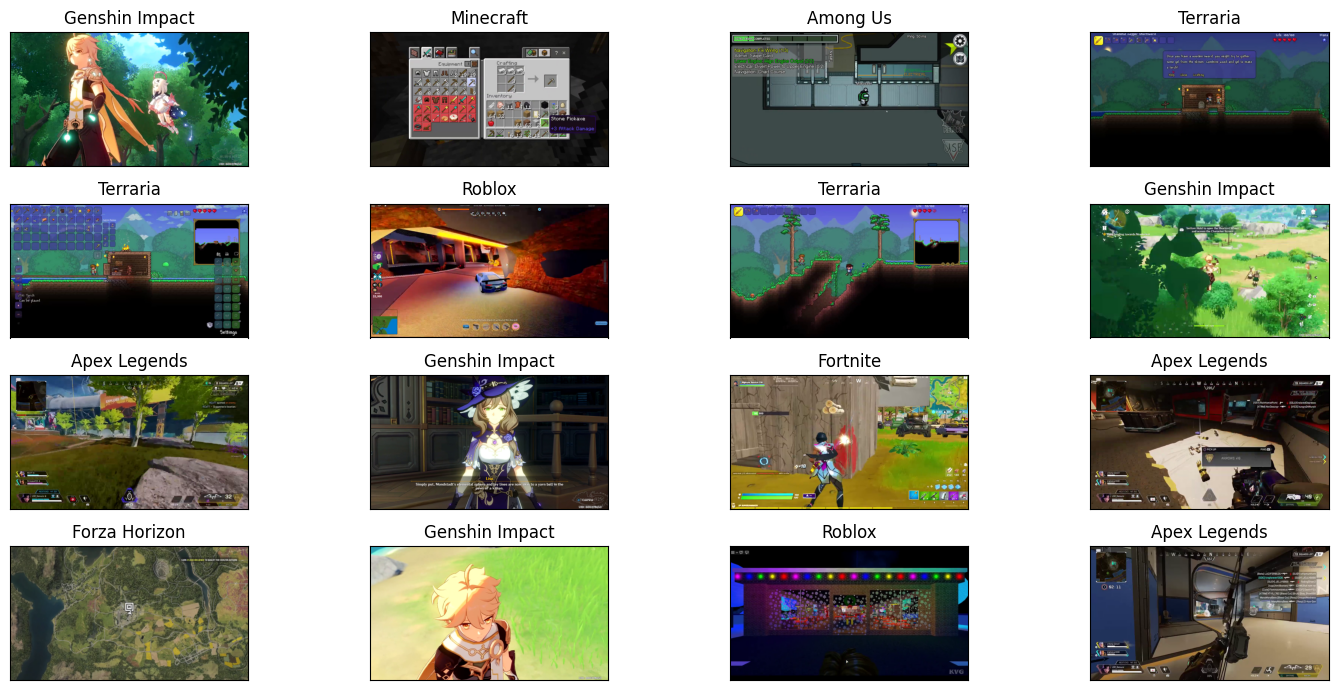

In [22]:


# Define the number of rows and columns in the grid
nrows = 4
ncols = 4

# Create a 4x4 grid of subplots for visualization
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 7), subplot_kw={'xticks': [], 'yticks': []})

# Loop through the subplots and display images with labels
for i, ax in enumerate(axes.flat):
    if i < len(data):
        # Load and display an image from the 'File_Path' and set the title as 'Labels'
        ax.imshow(plt.imread(data.File_Path[i]))  # Display the image
        ax.set_title(data.Labels[i])  # Set the title as the label
    else:
        # If there are no more images in the dataset, remove the empty subplot
        fig.delaxes(ax)

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()


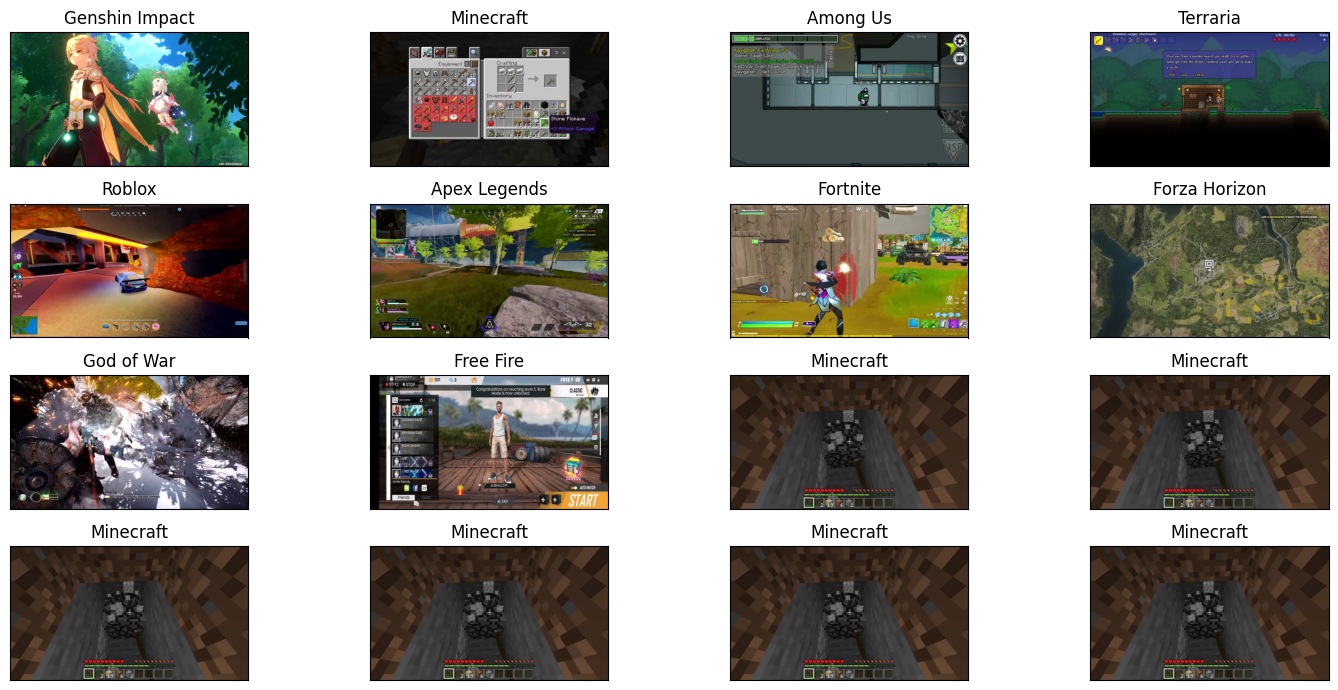

In [23]:


# Create a list to keep track of seen game classes
seen_classes = set()

# Create a 4x4 grid of subplots for visualization
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 7), subplot_kw={'xticks': [], 'yticks': []})

# Loop through the subplots and display one image from each game class
for i, ax in enumerate(axes.flat):
    # Find the next image with a new game class
    while data.Labels[i] in seen_classes and i < len(data) - 1:
        i += 1

    # Add the current game class to the set of seen classes
    seen_classes.add(data.Labels[i])

    # Load and display the selected image from the 'File_Path'
    ax.imshow(plt.imread(data.File_Path[i]))  # Display the image
    ax.set_title(data.Labels[i])  # Set the title as the label

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()


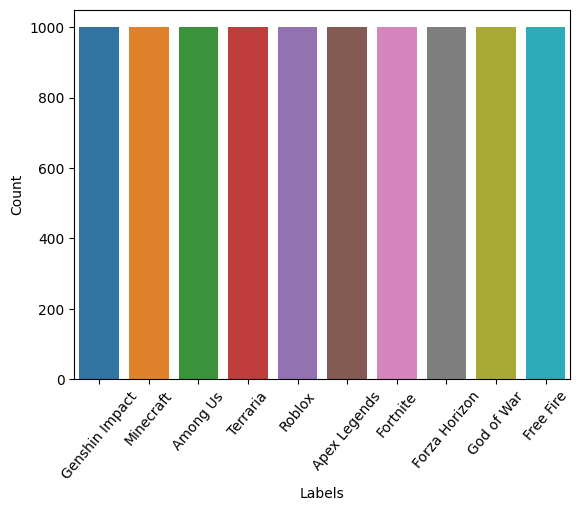

In [24]:
counts = data.Labels.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=50);

All data seen to be find and able to use


###images after augmentations

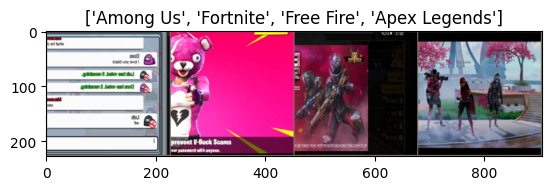

In [25]:
# Define the imshow function
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause for updating

# Get a batch from the 'train' dataloader
inputs, classes = next(iter(dataloaders['train']))

# Create a grid from the batch
out = torchvision.utils.make_grid(inputs)

# Display the images and their corresponding class labels
imshow(out, title=[class_names[x] for x in classes])

## Computing Error Rate Analysi

The code below is used for error level analysis (ELA) of images in the context of a game image classification task.

In [26]:
# Tensorflow Libraries
from tensorflow import keras
from keras.layers import Dense, Dropout

def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # read compressed image
    compressed_img = cv2.imread(temp_filename)

    # get absolute difference between img1 and img2 and multiply by scale
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff


def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    ela_filename = 'temp_ela.png'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    return ela_image

def random_sample(path, extension=None):
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')

    items = list(items)

    p = random.choice(items)
    return p.as_posix()

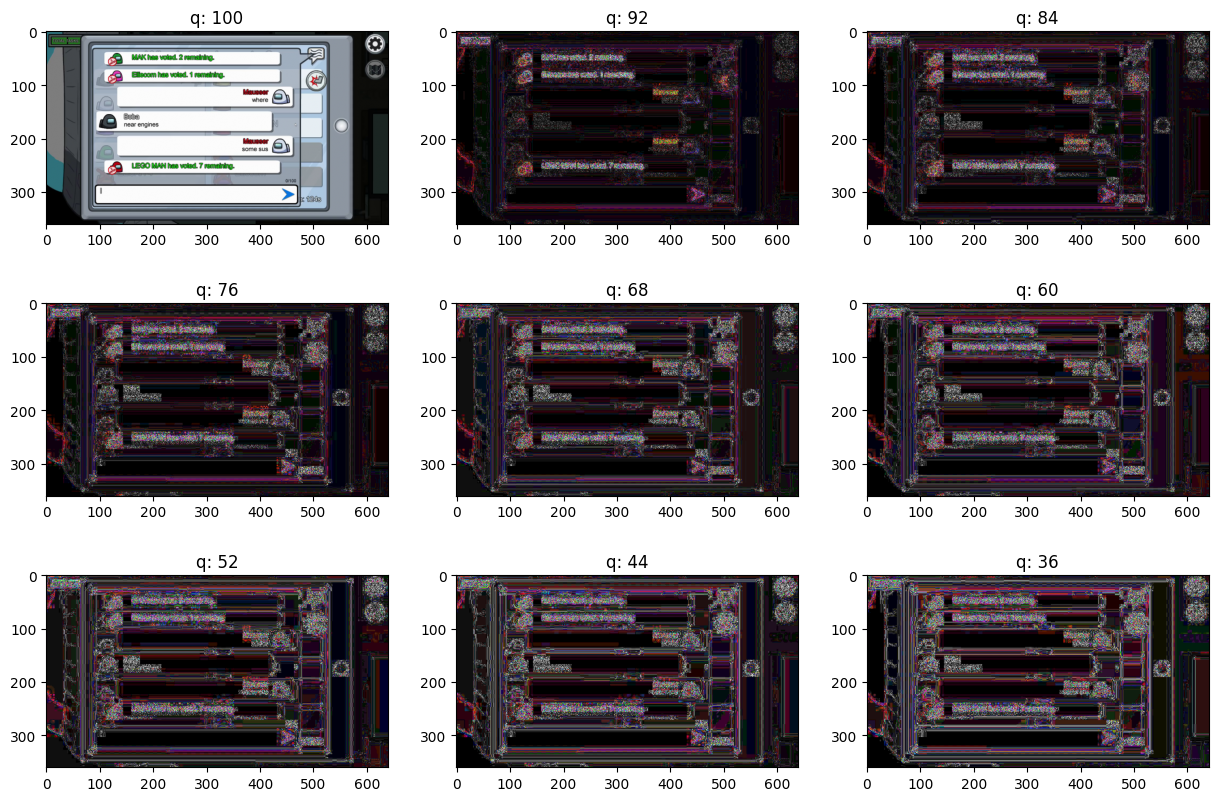

In [27]:
# View random sample from the dataset
p = random_sample('my-dataset/Dataset/Among Us')
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

fig=plt.figure(figsize=(15, 10))
for i in range(1, columns*rows +1):
    quality=init_val - (i-1) * 8
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i)
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()

Overall, this code provides a way to visually analyze the effect of different levels of JPEG compression on gaming images, and may be used to identify optimal quality levels for image compression in the context of a game image classification task.

## Train & Test Split

In [28]:
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, temp_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

# test dataframe
test_df, _ = train_test_split(temp_df,  train_size= 0.1, shuffle= True, random_state= 123)


In [29]:
num_of_classes(train_df, "Training "+ds_name)
num_of_classes(valid_df, "Validation "+ds_name)
num_of_classes(test_df, "Testing "+ds_name)

The Training Games dataset has 10 classes
The Validation Games dataset has 10 classes
The Testing Games dataset has 10 classes


In [30]:
classes_count(test_df, 'Testing '+ds_name)

The Testing Games dataset has: 

Class 'Among Us' has 10 images
----------------------------------------------------------------------
Class 'Apex Legends' has 6 images
----------------------------------------------------------------------
Class 'Minecraft' has 8 images
----------------------------------------------------------------------
Class 'Terraria' has 7 images
----------------------------------------------------------------------
Class 'Genshin Impact' has 8 images
----------------------------------------------------------------------
Class 'Roblox' has 6 images
----------------------------------------------------------------------
Class 'Forza Horizon' has 5 images
----------------------------------------------------------------------
Class 'Fortnite' has 13 images
----------------------------------------------------------------------
Class 'God of War' has 10 images
----------------------------------------------------------------------
Class 'Free Fire' has 7 images
--------

In [31]:
classes_count(train_df, 'Training '+ds_name)

The Training Games dataset has: 

Class 'Terraria' has 815 images
----------------------------------------------------------------------
Class 'Free Fire' has 796 images
----------------------------------------------------------------------
Class 'God of War' has 792 images
----------------------------------------------------------------------
Class 'Roblox' has 785 images
----------------------------------------------------------------------
Class 'Forza Horizon' has 788 images
----------------------------------------------------------------------
Class 'Genshin Impact' has 798 images
----------------------------------------------------------------------
Class 'Fortnite' has 821 images
----------------------------------------------------------------------
Class 'Apex Legends' has 810 images
----------------------------------------------------------------------
Class 'Among Us' has 795 images
----------------------------------------------------------------------
Class 'Minecraft' has 8

In [32]:
classes_count(valid_df, 'Val '+ds_name)

The Val Games dataset has: 

Class 'Genshin Impact' has 127 images
----------------------------------------------------------------------
Class 'God of War' has 115 images
----------------------------------------------------------------------
Class 'Minecraft' has 123 images
----------------------------------------------------------------------
Class 'Forza Horizon' has 122 images
----------------------------------------------------------------------
Class 'Roblox' has 124 images
----------------------------------------------------------------------
Class 'Terraria' has 116 images
----------------------------------------------------------------------
Class 'Among Us' has 127 images
----------------------------------------------------------------------
Class 'Free Fire' has 126 images
----------------------------------------------------------------------
Class 'Apex Legends' has 124 images
----------------------------------------------------------------------
Class 'Fortnite' has 96 ima

In [33]:
train_df, test_df = train_test_split(data, test_size=0.2, random_state=2)

In [65]:
import os
from shutil import copyfile

# Define the paths for the training and test datasets
training_data_folder = 'my-dataset/Dataset'
test_data_folder = 'my-dataset/test'

# Create test data for each class
class_labels = ["Among Us", "Apex Legends", "Fortnite", "Forza Horizon", "Free Fire", "Genshin Impact", "God of War", "Minecraft", "Roblox", "Terraria"]

for class_label in class_labels:
    class_folder_train = os.path.join(training_data_folder, class_label)
    class_folder_test = os.path.join(test_data_folder, class_label)

    os.makedirs(class_folder_test, exist_ok=True)

    # Get the path of the first image in the training dataset for each class
    image_path_train = os.path.join(class_folder_train, os.listdir(class_folder_train)[0])

    # Save a copy of the first image as "image_0.png" in the test dataset
    image_path_test = os.path.join(class_folder_test, 'image_0.png')
    copyfile(image_path_train, image_path_test)

print("Test data generation completed.")


Test data generation completed.


## Fuctions

In [67]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # There are training and validation phases in each epoch
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set the model in training mode
            else:
                model.eval()   # Set the model in evaluation mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate through batches of data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the gradients
                optimizer.zero_grad()

                # Forward pass through the model
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backpropagation and optimization only in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Calculate accuracy and loss for the batch
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # Update the learning rate in the training phase
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Save the best model based on validation accuracy
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f} min {time_elapsed % 60:.0f} sec')
    print(f'Best accuracy on validation: {best_acc:4f}')

    # Load the weights of the best model
    model.load_state_dict(best_model_wts)
    return model


In [68]:
def gen(pre,train,test):
    train_datagen = ImageDataGenerator(preprocessing_function=pre, validation_split=0.2)
    test_datagen = ImageDataGenerator(preprocessing_function=pre)

    train_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='File_Path',
        y_col='Labels',
        target_size=(100,100),
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")
    valid_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='File_Path',
        y_col='Labels',
        target_size=(100,100),
        class_mode='categorical',
        batch_size=32,
        shuffle=False,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")
    test_gen = test_datagen.flow_from_dataframe(
        dataframe=test,
        x_col='File_Path',
        y_col='Labels',
        target_size=(100,100),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        verbose=0,
        shuffle=False)
    return train_gen, valid_gen, test_gen
def func(name_model):
    pre_model = name_model(input_shape=(100,100, 3),
                   include_top=False,
                   weights='imagenet',
                   pooling='avg')
    pre_model.trainable = False
    inputs = pre_model.input
    x = Dense(100, activation='relu')(pre_model.output)
    x = Dense(100, activation='relu')(x)
    outputs = Dense(11, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss = 'categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
    my_callbacks  = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              mode='auto')]
    return model, my_callbacks

In [69]:
def func(name_model):
    pre_model = name_model(input_shape=(100,100, 3),
                   include_top=False,
                   weights='imagenet',
                   pooling='avg')
    pre_model.trainable = False
    inputs = pre_model.input
    x = Dense(100, activation='relu')(pre_model.output)
    x = Dense(100, activation='relu')(x)
    outputs = Dense(11, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss = 'categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
    my_callbacks  = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              mode='auto')]
    return model, my_callbacks

In [70]:
def plot(history,test_gen,train_gen,model):
    # Plotting Accuracy, val_accuracy, loss, val_loss
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax = ax.ravel()

    for i, met in enumerate(['accuracy', 'loss']):
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['Train', 'Validation'])

    # Predict Data Test
    pred = model.predict(test_gen )
    pred = np.argmax(pred,axis=1)
    labels = (train_gen.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]

    # Classification report
    cm=confusion_matrix(test_df.Labels,pred)
    clr = classification_report(test_df.Labels, pred)
    print(clr)
    # Display 6 picture of the dataset with their labels
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(test_df.File_Path.iloc[i+1]))
        ax.set_title(f"True: {test_df.Labels.iloc[i+1]}\nPredicted: {pred[i+1]}")
    plt.tight_layout()
    plt.show()

    return history

In [71]:
def result_test(test,model_use):
    results = model_use.evaluate(test, verbose=0)

    print("    Test Loss: {:.5f}".format(results[0]))
    print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    return results

In [72]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Split your 'data' DataFrame into training and testing sets
train_df, test_df = train_test_split(data, test_size=0.2, random_state=2)

# Define your data augmentation and generator function
def create_data_generators(preprocessing_function, train, test):
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocessing_function,
        validation_split=0.2
    )
    test_datagen = ImageDataGenerator(preprocessing_function=preprocessing_function)

    train_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='File_Path',  # Adjust this to match your column names
        y_col='Labels',  # Adjust this to match your column names
        target_size=(100, 100),  # Adjust the target size as needed
        class_mode='categorical',  # Depending on your labels
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    valid_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='File_Path',  # Adjust this to match your column names
        y_col='Labels',  # Adjust this to match your column names
        target_size=(100, 100),  # Adjust the target size as needed
        class_mode='categorical',  # Depending on your labels
        batch_size=32,
        shuffle=False,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_gen = test_datagen.flow_from_dataframe(
        dataframe=test,
        x_col='File_Path',  # Adjust this to match your column names
        y_col='Labels',  # Adjust this to match your column names
        target_size=(100, 100),  # Adjust the target size as needed
        color_mode='rgb',
        class_mode='categorical',  # Depending on your labels
        batch_size=32,
        verbose=0,
        shuffle=False
    )

    return train_gen, valid_gen, test_gen

In [73]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.applications.efficientnet import preprocess_input

# Assuming 'File_Path' is the correct column name for file paths
def create_data_generators(train, test):
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        validation_split=0.2
    )
    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

    train_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='File_Path',
        y_col='Labels',
        target_size=(100, 100),
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    valid_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='File_Path',
        y_col='Labels',
        target_size=(100, 100),
        class_mode='categorical',
        batch_size=32,
        shuffle=False,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_gen = test_datagen.flow_from_dataframe(
        dataframe=test,
        x_col='File_Path',
        y_col='Labels',
        target_size=(100, 100),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        verbose=0,
        shuffle=False
    )

    return train_gen, valid_gen, test_gen

# Split your 'data' DataFrame into training and testing sets
train_df, test_df = train_test_split(data, test_size=0.2, random_state=2)

# Create data generators with your preprocessing function and dataframes
train_gen, valid_gen, test_gen = create_data_generators(train_df, test_df)


Found 6400 validated image filenames belonging to 10 classes.
Found 1600 validated image filenames belonging to 10 classes.
Found 2000 validated image filenames belonging to 10 classes.


In [74]:
def create_data_generators(train, test, preprocessing_function):
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocessing_function,
        validation_split=0.2
    )
    test_datagen = ImageDataGenerator(preprocessing_function=preprocessing_function)

    train_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='File_Path',
        y_col='Labels',
        target_size=(100, 100),
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    valid_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='File_Path',
        y_col='Labels',
        target_size=(100, 100),
        class_mode='categorical',
        batch_size=32,
        shuffle=False,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_gen = test_datagen.flow_from_dataframe(
        dataframe=test,
        x_col='File_Path',
        y_col='Labels',
        target_size=(100, 100),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        verbose=0,
        shuffle=False
    )

    return train_gen, valid_gen, test_gen


In [75]:
train_gen, valid_gen, test_gen = create_data_generators(train_df, test_df, preprocess_input)


Found 6400 validated image filenames belonging to 10 classes.
Found 1600 validated image filenames belonging to 10 classes.
Found 2000 validated image filenames belonging to 10 classes.


### Visualizing Model

In [76]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


##Visualize Training dataset

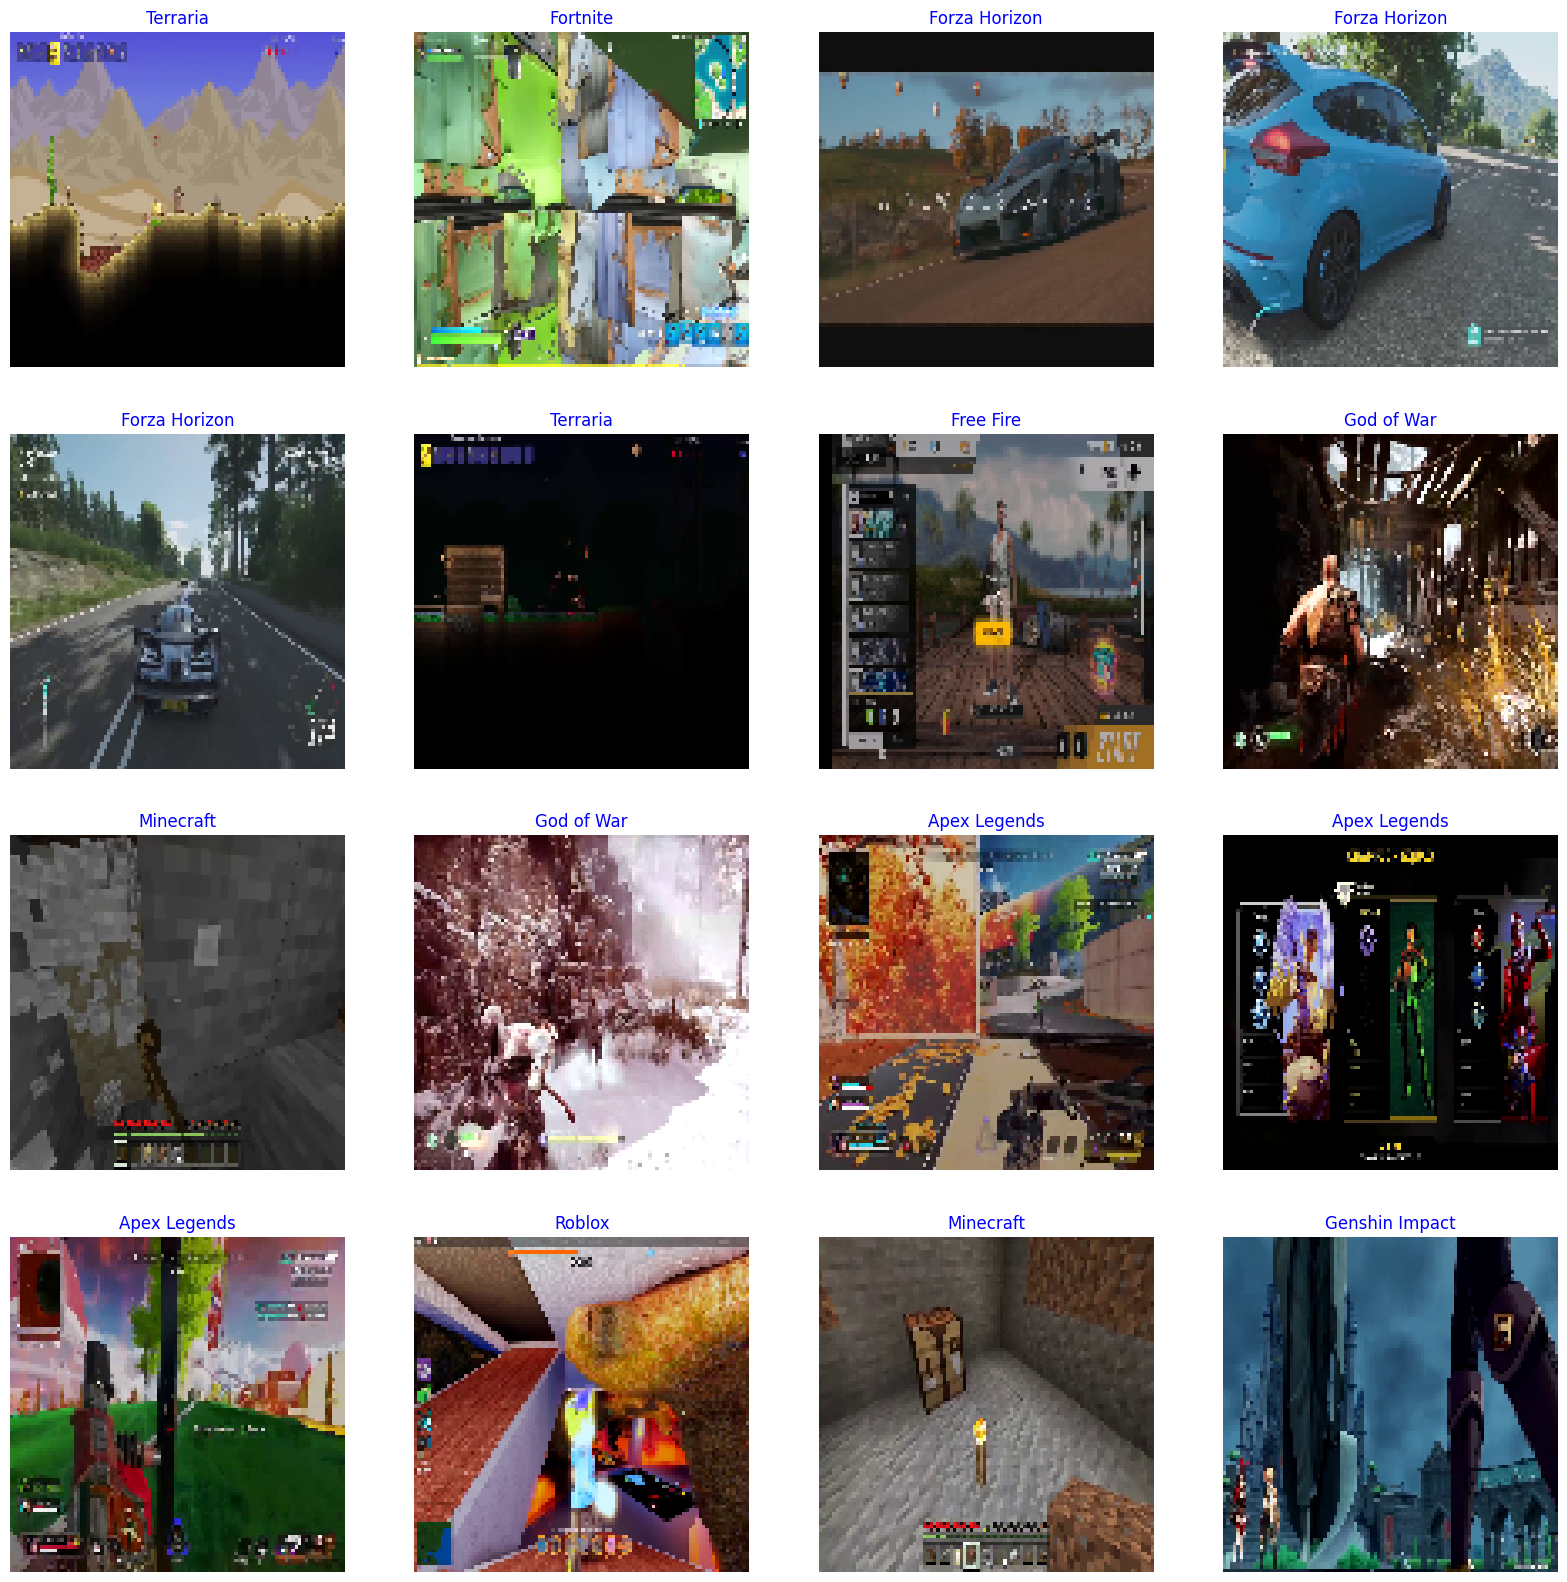

In [ ]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')

plt.show()

## Method 1: Finetuning for Convolutional Networks

In [80]:
import torch.optim as optim
from torch.optim import lr_scheduler



model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
out_ftrs = len(class_names)
model_ft.fc = nn.Linear(num_ftrs, out_ftrs)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Update weights for the entire model
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decrease LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


In [81]:
model_ft = train_model(model_ft, criterion, optimizer_ft,
                       exp_lr_scheduler, num_epochs=50)

Epoch 0/49
----------
train Loss: 0.8017 Acc: 0.7399
val Loss: 0.1348 Acc: 0.9575

Epoch 1/49
----------
train Loss: 0.5171 Acc: 0.8377
val Loss: 0.0792 Acc: 0.9755

Epoch 2/49
----------
train Loss: 0.4265 Acc: 0.8635
val Loss: 0.0634 Acc: 0.9780

Epoch 3/49
----------
train Loss: 0.3703 Acc: 0.8809
val Loss: 0.0936 Acc: 0.9715

Epoch 4/49
----------
train Loss: 0.3331 Acc: 0.8999
val Loss: 0.0639 Acc: 0.9780

Epoch 5/49
----------
train Loss: 0.2948 Acc: 0.9095
val Loss: 0.0493 Acc: 0.9855

Epoch 6/49
----------
train Loss: 0.2840 Acc: 0.9103
val Loss: 0.0626 Acc: 0.9825

Epoch 7/49
----------
train Loss: 0.1753 Acc: 0.9467
val Loss: 0.0419 Acc: 0.9890

Epoch 8/49
----------
train Loss: 0.1601 Acc: 0.9531
val Loss: 0.0426 Acc: 0.9895

Epoch 9/49
----------
train Loss: 0.1438 Acc: 0.9575
val Loss: 0.0386 Acc: 0.9900

Epoch 10/49
----------
train Loss: 0.1530 Acc: 0.9543
val Loss: 0.0392 Acc: 0.9910

Epoch 11/49
----------
train Loss: 0.1404 Acc: 0.9570
val Loss: 0.0416 Acc: 0.9900

Ep

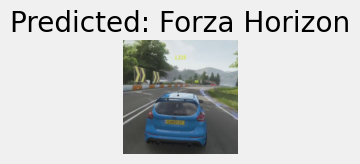

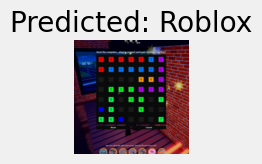

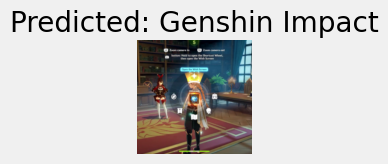

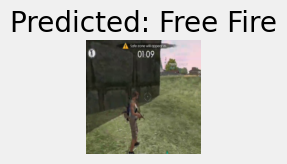

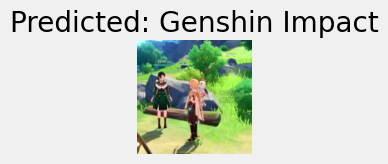

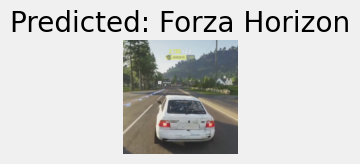

In [82]:
visualize_model(model_ft)

In [92]:
from sklearn.metrics import f1_score, classification_report

def evaluate_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

# Assuming you have a DataLoader named test_loader
test_preds, test_labels = evaluate_model(model_ft, test_loader)

# Calculate F1 score for each class
class_f1_scores = f1_score(test_labels, test_preds, average=None)

# Calculate overall F1 score
overall_f1_score = f1_score(test_labels, test_preds, average='weighted')

# Print class-wise F1 scores
print("Class-wise F1 scores:")
for class_name, f1_score_val in zip(class_names, class_f1_scores):
    print(f"{class_name}: {f1_score_val}")

# Print overall F1 score
print(f"Overall F1 score: {overall_f1_score}")

# Display detailed classification report
print("Classification Report:")
print(classification_report(test_labels, test_preds, target_names=class_names))



Class-wise F1 scores:
Among Us: 0.18181818181818182
Apex Legends: 0.18181818181818182
Fortnite: 0.18181818181818182
Forza Horizon: 0.198019801980198
Free Fire: 0.18181818181818182
Genshin Impact: 0.18181818181818182
God of War: 0.18181818181818182
Minecraft: 0.18181818181818182
Roblox: 0.18181818181818182
Terraria: 0.18181818181818182
Overall F1 score: 0.18343834383438348
Classification Report:
                precision    recall  f1-score   support

      Among Us       1.00      0.10      0.18        10
  Apex Legends       1.00      0.10      0.18        10
      Fortnite       1.00      0.10      0.18        10
 Forza Horizon       0.11      1.00      0.20        10
     Free Fire       1.00      0.10      0.18        10
Genshin Impact       1.00      0.10      0.18        10
    God of War       1.00      0.10      0.18        10
     Minecraft       1.00      0.10      0.18        10
        Roblox       1.00      0.10      0.18        10
      Terraria       1.00      0.10      

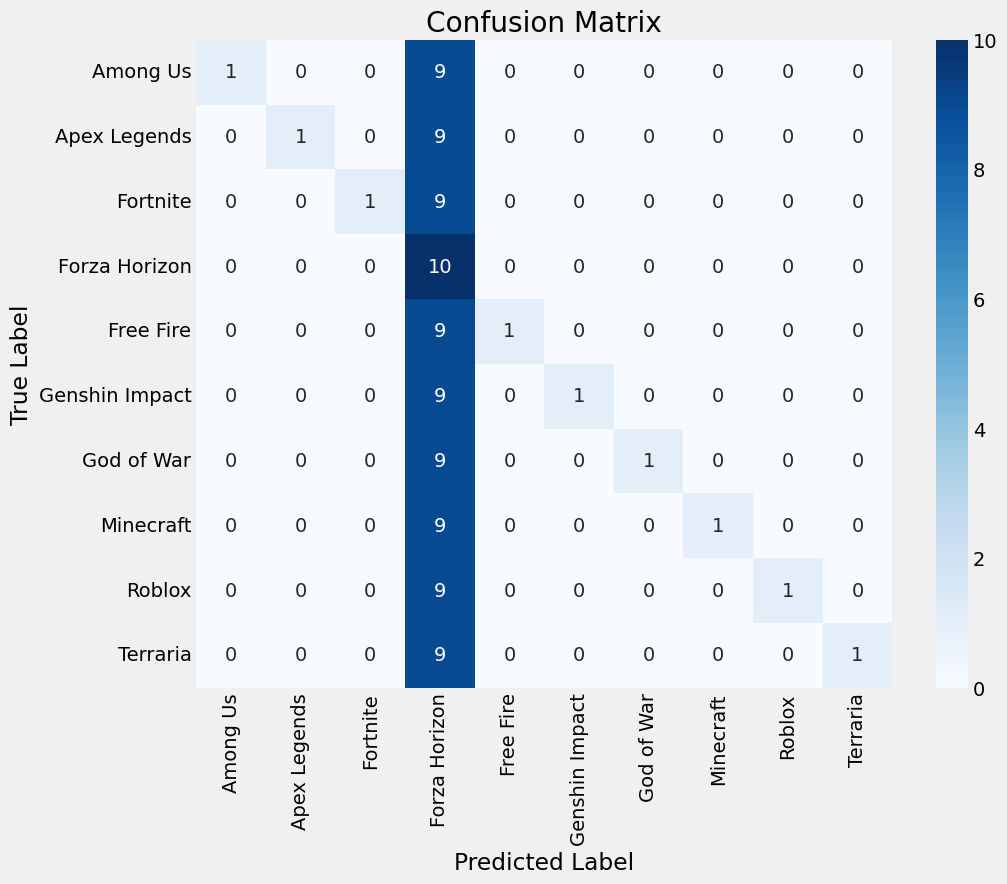

In [91]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get the confusion matrix
conf_matrix = confusion_matrix(test_labels, test_preds)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


### Saving model for later use

### Testing the Acc of Gameplay images classification  

## Method 2: Convolutional Network as a Frozen Feature Extractor

In [83]:
model_conv = torchvision.models.resnet18(pretrained=True)

# Freeze the parameters
for param in model_conv.parameters():
    param.requires_grad = False

# The new fully connected layer has requires_grad=True by default
num_ftrs = model_conv.fc.in_features
out_ftrs = len(class_names)
model_conv.fc = nn.Linear(num_ftrs, out_ftrs)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Update weights for only the fully connected layer
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decrease LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


In [84]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=50)

Epoch 0/49
----------
train Loss: 1.0591 Acc: 0.6566
val Loss: 0.3760 Acc: 0.8710

Epoch 1/49
----------
train Loss: 0.7833 Acc: 0.7444
val Loss: 0.2790 Acc: 0.9140

Epoch 2/49
----------
train Loss: 0.7375 Acc: 0.7585
val Loss: 0.2648 Acc: 0.9155

Epoch 3/49
----------
train Loss: 0.6687 Acc: 0.7792
val Loss: 0.2496 Acc: 0.9140

Epoch 4/49
----------
train Loss: 0.6801 Acc: 0.7791
val Loss: 0.2313 Acc: 0.9190

Epoch 5/49
----------
train Loss: 0.6956 Acc: 0.7776
val Loss: 0.1876 Acc: 0.9370

Epoch 6/49
----------
train Loss: 0.6884 Acc: 0.7796
val Loss: 0.2372 Acc: 0.9180

Epoch 7/49
----------
train Loss: 0.5562 Acc: 0.8175
val Loss: 0.1677 Acc: 0.9435

Epoch 8/49
----------
train Loss: 0.5494 Acc: 0.8254
val Loss: 0.1764 Acc: 0.9405

Epoch 9/49
----------
train Loss: 0.5609 Acc: 0.8231
val Loss: 0.1877 Acc: 0.9350

Epoch 10/49
----------
train Loss: 0.5566 Acc: 0.8247
val Loss: 0.1895 Acc: 0.9395

Epoch 11/49
----------
train Loss: 0.5423 Acc: 0.8216
val Loss: 0.1998 Acc: 0.9330

Ep

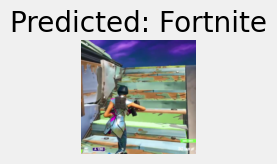

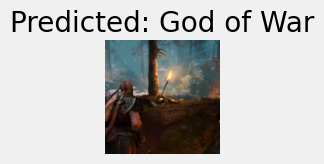

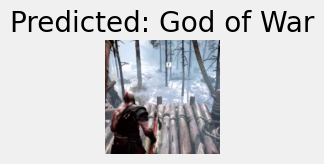

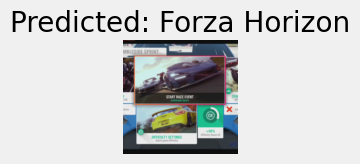

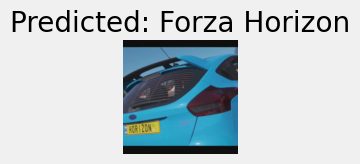

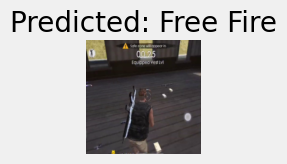

In [85]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [97]:
from sklearn.metrics import classification_report, confusion_matrix

# Set the model to evaluation mode
model_conv.eval()

# Lists to store true labels and predicted labels
y_true = []
y_pred = []

# Iterate through the test data
with torch.no_grad():
    for inputs, labels in test_loader:  # Assuming you have a DataLoader for your test data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_conv(inputs)
        _, predicted = torch.max(outputs, 1)

        # Append true and predicted labels
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Convert predictions to class labels
class_labels = list(train_gen.class_indices.keys())
y_true_labels = [class_labels[i] for i in y_true]
y_pred_labels = [class_labels[i] for i in y_pred]

# Generate classification report and confusion matrix
classification_rep = classification_report(y_true_labels, y_pred_labels, target_names=class_labels)
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Print classification report
print(classification_rep)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)


                precision    recall  f1-score   support

      Among Us       1.00      0.10      0.18        10
  Apex Legends       1.00      0.10      0.18        10
      Fortnite       1.00      0.10      0.18        10
 Forza Horizon       0.11      1.00      0.20        10
     Free Fire       1.00      0.10      0.18        10
Genshin Impact       1.00      0.10      0.18        10
    God of War       1.00      0.10      0.18        10
     Minecraft       1.00      0.10      0.18        10
        Roblox       1.00      0.10      0.18        10
      Terraria       1.00      0.10      0.18        10

      accuracy                           0.19       100
     macro avg       0.91      0.19      0.18       100
  weighted avg       0.91      0.19      0.18       100

Confusion Matrix:
[[ 1  0  0  9  0  0  0  0  0  0]
 [ 0  1  0  9  0  0  0  0  0  0]
 [ 0  0  1  9  0  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0  0]
 [ 0  0  0  9  1  0  0  0  0  0]
 [ 0  0  0  9  0  1  0  0  0  

### Saving model

In [ ]:
import os

# Define the directory where you want to save the model
model_save_dir = 'model'

# Ensure the directory exists
os.makedirs(model_save_dir, exist_ok=True)

# Define the filename for your model
model_filename = 'your_model_2.pth'

# Combine the directory and filename to create the full model path
model_save_path = os.path.join(model_save_dir, model_filename)

# Save the model's state dictionary
torch.save(model_conv.state_dict(), model_save_path)

# Now your model is saved at model_save_pat

### Testing model

In [ ]:
# Load and preprocess the input image
from PIL import Image
img_path = 'my-dataset/Dataset/Roblox/image_103.png'
img = Image.open(img_path)
img = preprocess(img)
img = img.unsqueeze(0)  # Add a batch dimension
# Move the input tensor to the same device as the model
img = img.to(device)


# Set the model to evaluation mode
model_conv.eval()

# Perform inference
with torch.no_grad():
    outputs = model_conv(img)

# Get the predicted class
_, predicted = torch.max(outputs, 1)
predicted_class = predicted.item()

In [ ]:
class_names = ["Minecraft", "Roblox","Among Us", "God of War","Apex Legends","Forza Horizon","Free Fire","Genshin Impact","Terraria"]

predicted_label = class_names[predicted_class]
print(f"Predicted Label: {predicted_label}")

Predicted Label: Terraria


## Method 3: EfficientNetB7

Generic Model Creation

In [44]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB7(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
base_model.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(1000, kernel_regularizer=regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dropout(rate=0.45, seed=123),
    Dense(128, kernel_regularizer=regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dropout(rate=0.45, seed=123),
    Dense(64, kernel_regularizer=regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dropout(rate=0.45, seed=123),
    Dense(class_count, activation='softmax')
])
model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

258076736/258076736 [==============================] - 13s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional  (None, 2560)              64097687  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 2560)              10240     
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 1000)              2561000   
                                                                 
 dropout (Dropout)           (None, 1000)              0         
                                                                 
 dense_1 (Dense)             (None, 128)               128128    
                                                      

In [45]:
early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=5,
                               restore_best_weights=True,
                               mode='max',
                              )

def step_decay(epoch):

     initial_lrate = 0.1
     drop = 0.5
     epochs_drop = 10.0
     lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
     return lrate

lr_scheduler = LearningRateScheduler(step_decay)

Train Model

In [46]:

batch_size = 64   # set batch size for training
epochs = 50   # number of all epochs in training

history = model.fit(x=train_gen,
                    epochs= epochs,
                    verbose= 1,
                    validation_data= valid_gen,
                    validation_steps= None,
                    shuffle= False,
                    batch_size= batch_size)

Epoch 1/50
200/200 [==============================] - 99s 340ms/step - loss: 25.1923 - accuracy: 0.3517 - val_loss: 17.6677 - val_accuracy: 0.7444
Epoch 2/50
200/200 [==============================] - 62s 310ms/step - loss: 13.9786 - accuracy: 0.6008 - val_loss: 10.1397 - val_accuracy: 0.8456
Epoch 3/50
200/200 [==============================] - 62s 310ms/step - loss: 8.2848 - accuracy: 0.7448 - val_loss: 6.2484 - val_accuracy: 0.8875
Epoch 4/50
200/200 [==============================] - 62s 310ms/step - loss: 5.3972 - accuracy: 0.8163 - val_loss: 4.1886 - val_accuracy: 0.9181
Epoch 5/50
200/200 [==============================] - 62s 310ms/step - loss: 3.8078 - accuracy: 0.8653 - val_loss: 3.0426 - val_accuracy: 0.9156
Epoch 6/50
200/200 [==============================] - 62s 309ms/step - loss: 2.8688 - accuracy: 0.8811 - val_loss: 2.3268 - val_accuracy: 0.9294
Epoch 7/50
200/200 [==============================] - 61s 307ms/step - loss: 2.3177 - accuracy: 0.8959 - val_loss: 1.9133 - va

Plot accuarcy and loss curve

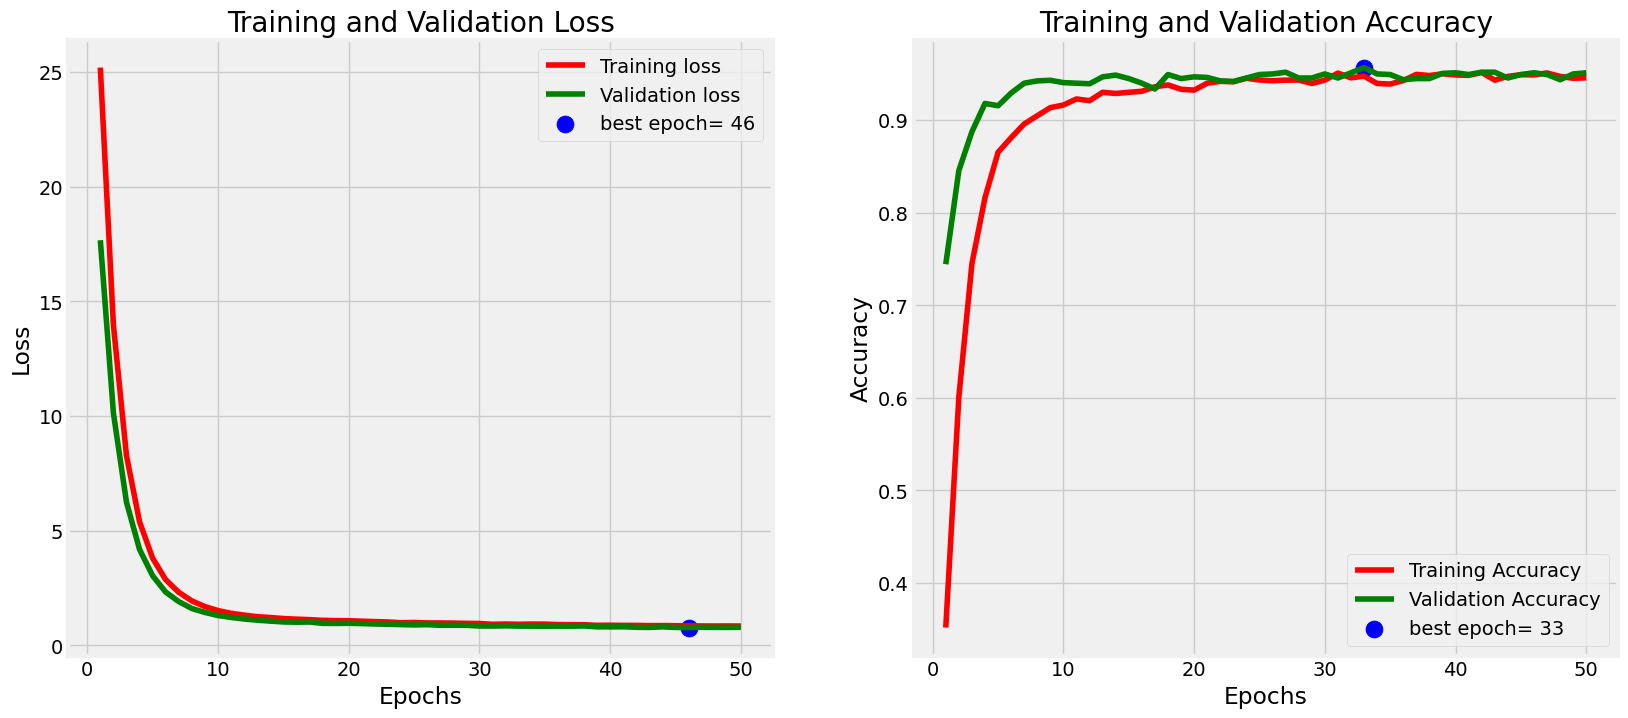

In [47]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

Model Accuarcy

In [48]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

25/25 [==============================] - 6s 254ms/step - loss: 0.7706 - accuracy: 0.9500
Train Loss:  0.6572573781013489
Train Accuracy:  0.9862499833106995
--------------------
Validation Loss:  0.7842941284179688
Validation Accuracy:  0.9524999856948853
--------------------
Test Loss:  0.7705949544906616
Test Accuracy:  0.949999988079071


In [49]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

Confussion Matrix

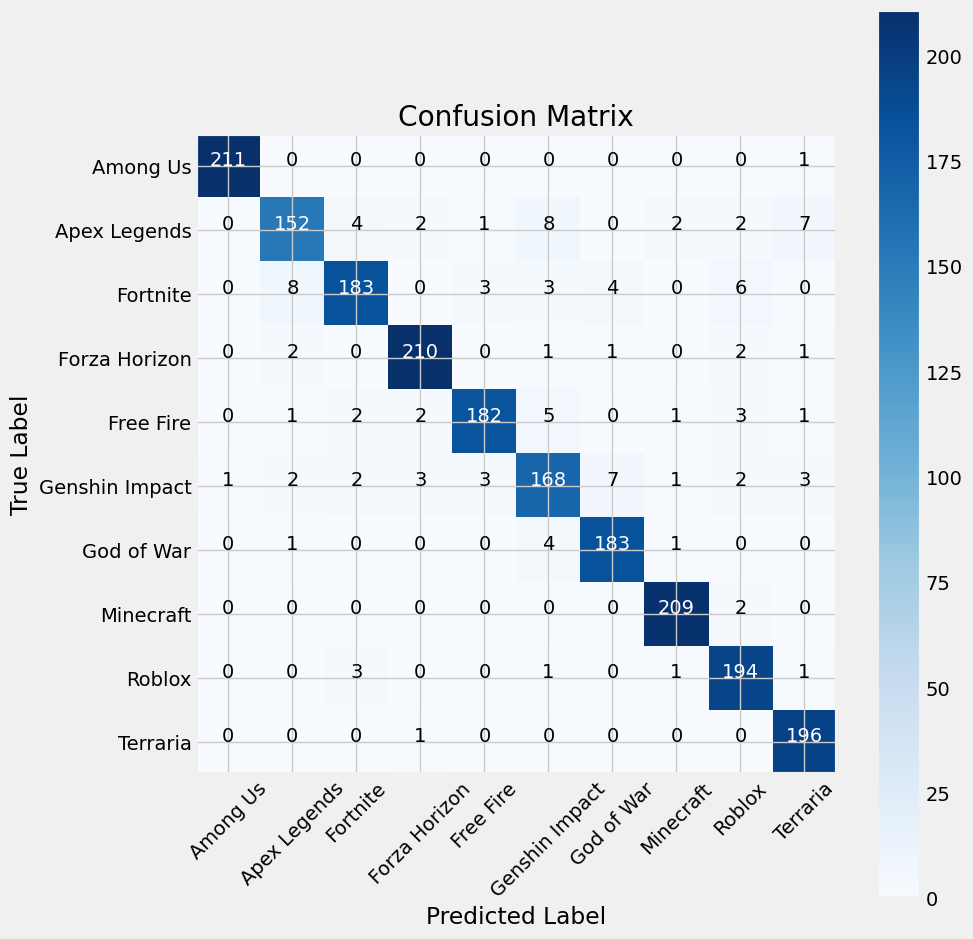

In [50]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [51]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

                precision    recall  f1-score   support

      Among Us       1.00      1.00      1.00       212
  Apex Legends       0.92      0.85      0.88       178
      Fortnite       0.94      0.88      0.91       207
 Forza Horizon       0.96      0.97      0.97       217
     Free Fire       0.96      0.92      0.94       197
Genshin Impact       0.88      0.88      0.88       192
    God of War       0.94      0.97      0.95       189
     Minecraft       0.97      0.99      0.98       211
        Roblox       0.92      0.97      0.94       200
      Terraria       0.93      0.99      0.96       197

      accuracy                           0.94      2000
     macro avg       0.94      0.94      0.94      2000
  weighted avg       0.94      0.94      0.94      2000



In [52]:
model.save_weights('my_model_weights.h5')

Load the model and Predict the Inputs

In [55]:
# Evaluate the model on the test data
test_score = model.evaluate(test_gen, verbose=1)

print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])


63/63 [==============================] - 15s 243ms/step - loss: 0.7843 - accuracy: 0.9440
Test Loss:  0.7843230366706848
Test Accuracy:  0.9440000057220459


1/1 [==============================] - 0s 45ms/step


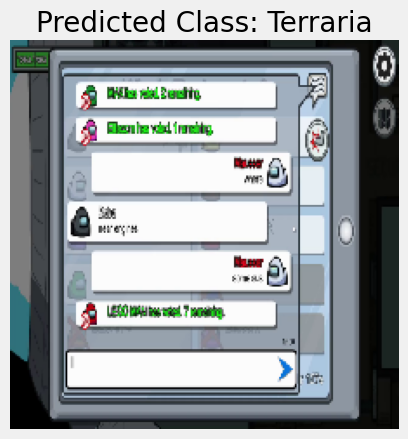

1/1 [==============================] - 0s 43ms/step


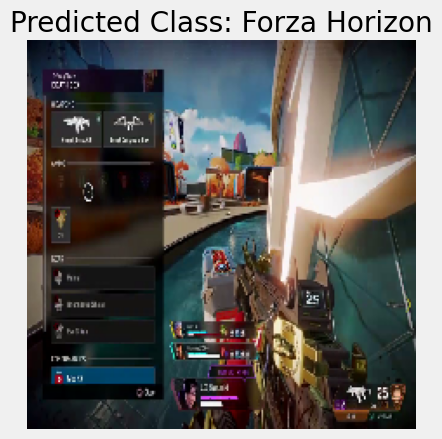

1/1 [==============================] - 0s 42ms/step


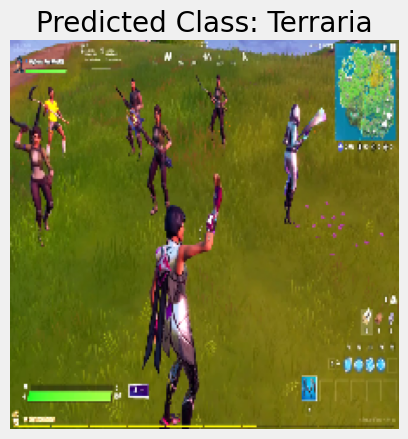

1/1 [==============================] - 0s 43ms/step


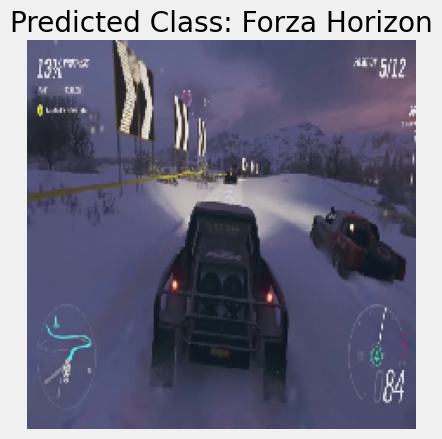

1/1 [==============================] - 0s 41ms/step


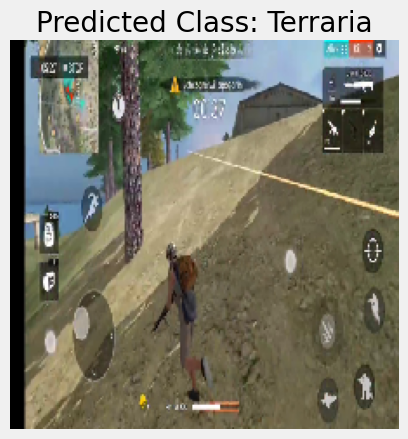

1/1 [==============================] - 0s 43ms/step


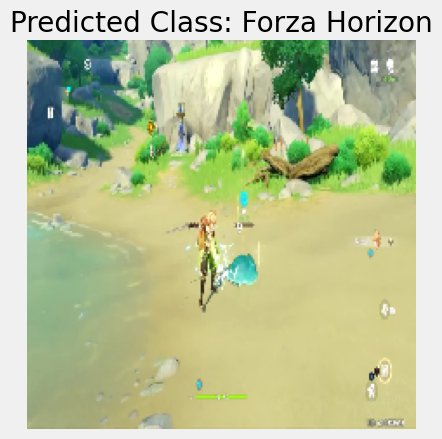

1/1 [==============================] - 0s 42ms/step


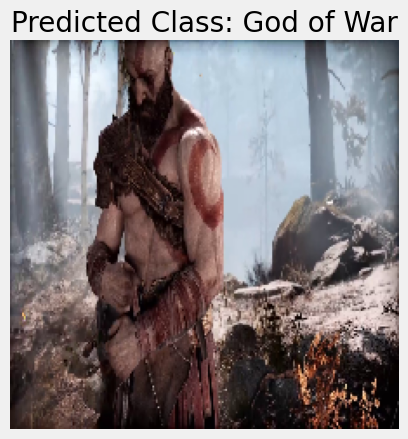

1/1 [==============================] - 0s 43ms/step


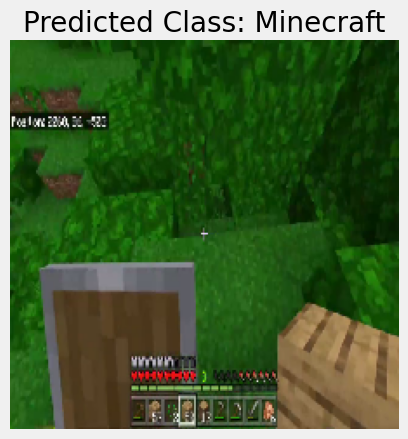

1/1 [==============================] - 0s 41ms/step


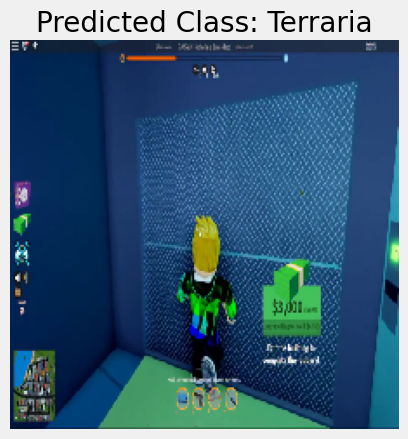

1/1 [==============================] - 0s 42ms/step


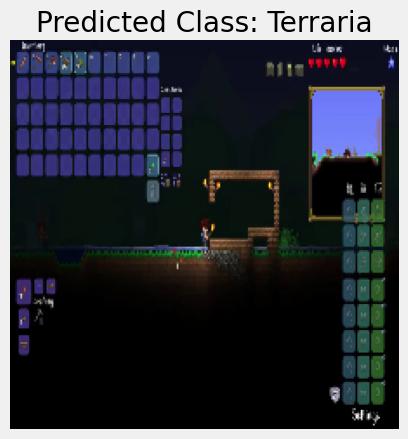

In [77]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
import numpy as np

# Function to predict and display an image
def predict_and_display(image_path, model, class_labels):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)
    predicted_class_label = class_labels[predicted_class_index]

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted Class: {predicted_class_label}")
    plt.show()

# Load your trained model
model.load_weights('my_model_weights.h5')

# Define your class labels
class_labels = ["Among Us", "Apex Legends", "Fortnite", "Forza Horizon", "Free Fire", "Genshin Impact", "God of War", "Minecraft", "Roblox", "Terraria"]

# Path to the folder containing test images for each class
test_data_folder = 'my-dataset/test'

# Iterate through each class and display predictions
for class_label in class_labels:
    image_path_to_test = f'{test_data_folder}/{class_label}/image_0.png'
    predict_and_display(image_path_to_test, model, class_labels)


image Classificaation using SVM is very efficient way of modelling and very rarely used algorithm for image processing and modelling

## Method 4: MoblieNet

In [98]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adamax

# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))  # to define the number of classes in dense layer

# Create pre-trained MobileNetV2 model
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=img_shape, pooling='max')
base_model.trainable = False

# Define your model with a different name
custom_model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(1000, kernel_regularizer=regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dropout(rate=0.45, seed=123),
    Dense(128, kernel_regularizer=regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dropout(rate=0.45, seed=123),
    Dense(64, kernel_regularizer=regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dropout(rate=0.45, seed=123),
    Dense(class_count, activation='softmax')
], name='my_custom_model')


custom_model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

custom_model.summary()


9406464/9406464 [==============================] - 1s 0us/step
Model: "my_custom_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 batch_normalization_1 (Bat  (None, 1280)              5120      
 chNormalization)                                                
                                                                 
 dense_4 (Dense)             (None, 1000)              1281000   
                                                                 
 dropout_3 (Dropout)         (None, 1000)              0         
                                                                 
 dense_5 (Dense)             (None, 128)               128128    
                                                      

In [ ]:

batch_size = 64   # set batch size for training
epochs = 60   # number of all epochs in training

history = custom_model.fit(x=train_gen,
                    epochs= epochs,
                    verbose= 1,
                    validation_data= valid_gen,
                    validation_steps= None,
                    shuffle= False,
                    batch_size= batch_size)

Epoch 1/60
200/200 [==============================] - 64s 301ms/step - loss: 20.7314 - accuracy: 0.2639 - val_loss: 15.0352 - val_accuracy: 0.5494
Epoch 2/60
200/200 [==============================] - 59s 297ms/step - loss: 11.6819 - accuracy: 0.4720 - val_loss: 8.6673 - val_accuracy: 0.7200
Epoch 3/60
200/200 [==============================] - 59s 296ms/step - loss: 7.0488 - accuracy: 0.5944 - val_loss: 5.4148 - val_accuracy: 0.7538
Epoch 4/60
200/200 [==============================] - 59s 296ms/step - loss: 4.6671 - accuracy: 0.6805 - val_loss: 3.7043 - val_accuracy: 0.7900
Epoch 5/60
200/200 [==============================] - 59s 296ms/step - loss: 3.3845 - accuracy: 0.7275 - val_loss: 2.7787 - val_accuracy: 0.7969
Epoch 6/60
200/200 [==============================] - 59s 298ms/step - loss: 2.6407 - accuracy: 0.7605 - val_loss: 2.2221 - val_accuracy: 0.8081
Epoch 7/60
200/200 [==============================] - 59s 296ms/step - loss: 2.2044 - accuracy: 0.7811 - val_loss: 1.9223 - val

In [ ]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import load_model  # Add this import statement

In [ ]:
# Save the entire model after training
custom_model.save('my_trained_model.h5')

# Save only the weights if needed
custom_model.save_weights('my_trained_model_weights.h5')

# Load the model if needed
loaded_model = load_model('my_trained_model.h5')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import load_model

# Load your trained model
custom_model = load_model('my_trained_model.h5')  # Replace with your model file


class_labels = ["Among Us", "Apex Legends", "Fortnite", "Forza Horizon", "Free Fire", "Genshin Impact", "God of War", "Minecraft", "Roblox", "Terraria"]

def predict_and_display(image_path, custom_model, class_labels):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    prediction = custom_model.predict(img_array)
    predicted_class_index = np.argmax(prediction)

    predicted_class_label = class_labels[predicted_class_index]

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted Game: {predicted_class_label}")
    plt.show()

    # Print additional information for debugging
    print("Prediction Scores:", prediction)
    print("Predicted Class Index:", predicted_class_index)
    print("Predicted Class Label:", predicted_class_label)

# Replace 'path_to_test_image' with the path to the image you want to test
image_path_to_test = 'my-dataset/train/Fortnite/image_120.png'
predict_and_display(image_path_to_test, custom_model, class_labels)


63/63 [==============================] - 16s 244ms/step - loss: 1.0132 - accuracy: 0.8720
Test Loss: 1.0132125616073608
Test Accuracy: 0.871999979019165
63/63 [==============================] - 16s 237ms/step


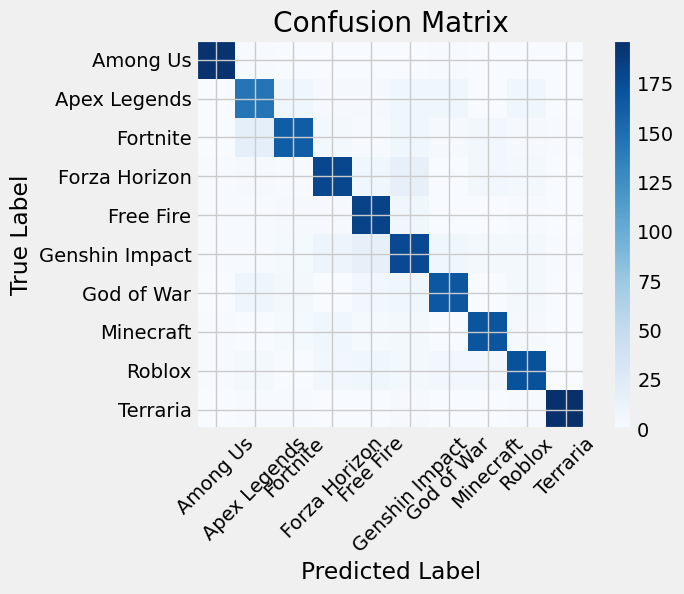

                precision    recall  f1-score   support

      Among Us       0.97      0.99      0.98       196
  Apex Legends       0.80      0.82      0.81       177
      Fortnite       0.89      0.81      0.84       202
 Forza Horizon       0.85      0.83      0.84       215
     Free Fire       0.82      0.93      0.87       196
Genshin Impact       0.77      0.79      0.78       224
    God of War       0.88      0.85      0.87       196
     Minecraft       0.90      0.89      0.90       189
        Roblox       0.87      0.84      0.86       203
      Terraria       0.99      0.98      0.98       202

      accuracy                           0.87      2000
     macro avg       0.87      0.87      0.87      2000
  weighted avg       0.87      0.87      0.87      2000



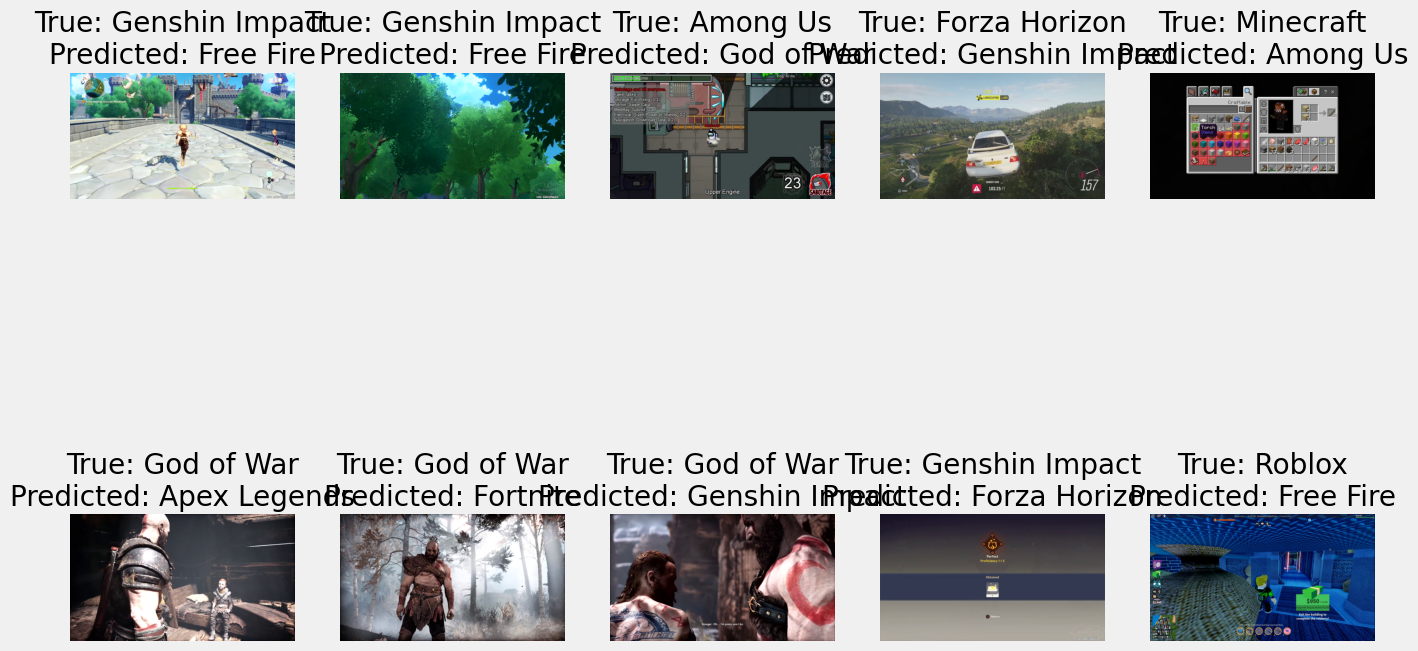

63/63 [==============================] - 15s 234ms/step - loss: 1.0132 - accuracy: 0.8720
Test Loss: 1.0132125616073608
Test Accuracy: 0.871999979019165
63/63 [==============================] - 15s 235ms/step


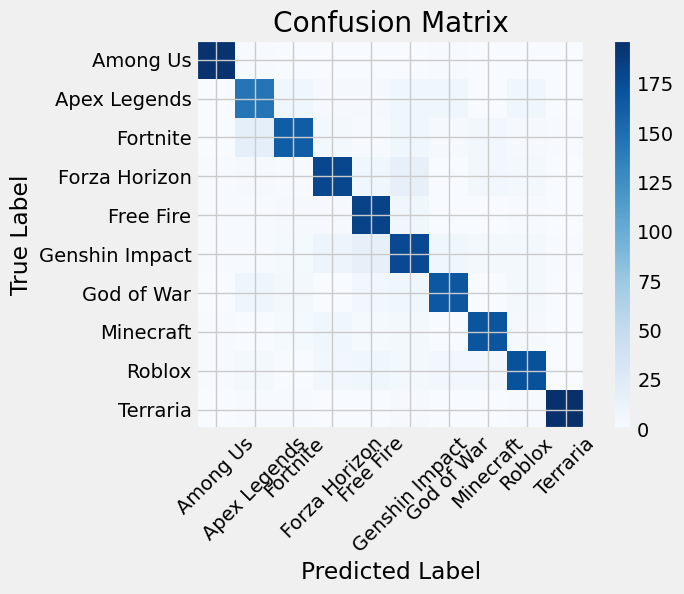

                precision    recall  f1-score   support

      Among Us       0.97      0.99      0.98       196
  Apex Legends       0.80      0.82      0.81       177
      Fortnite       0.89      0.81      0.84       202
 Forza Horizon       0.85      0.83      0.84       215
     Free Fire       0.82      0.93      0.87       196
Genshin Impact       0.77      0.79      0.78       224
    God of War       0.88      0.85      0.87       196
     Minecraft       0.90      0.89      0.90       189
        Roblox       0.87      0.84      0.86       203
      Terraria       0.99      0.98      0.98       202

      accuracy                           0.87      2000
     macro avg       0.87      0.87      0.87      2000
  weighted avg       0.87      0.87      0.87      2000



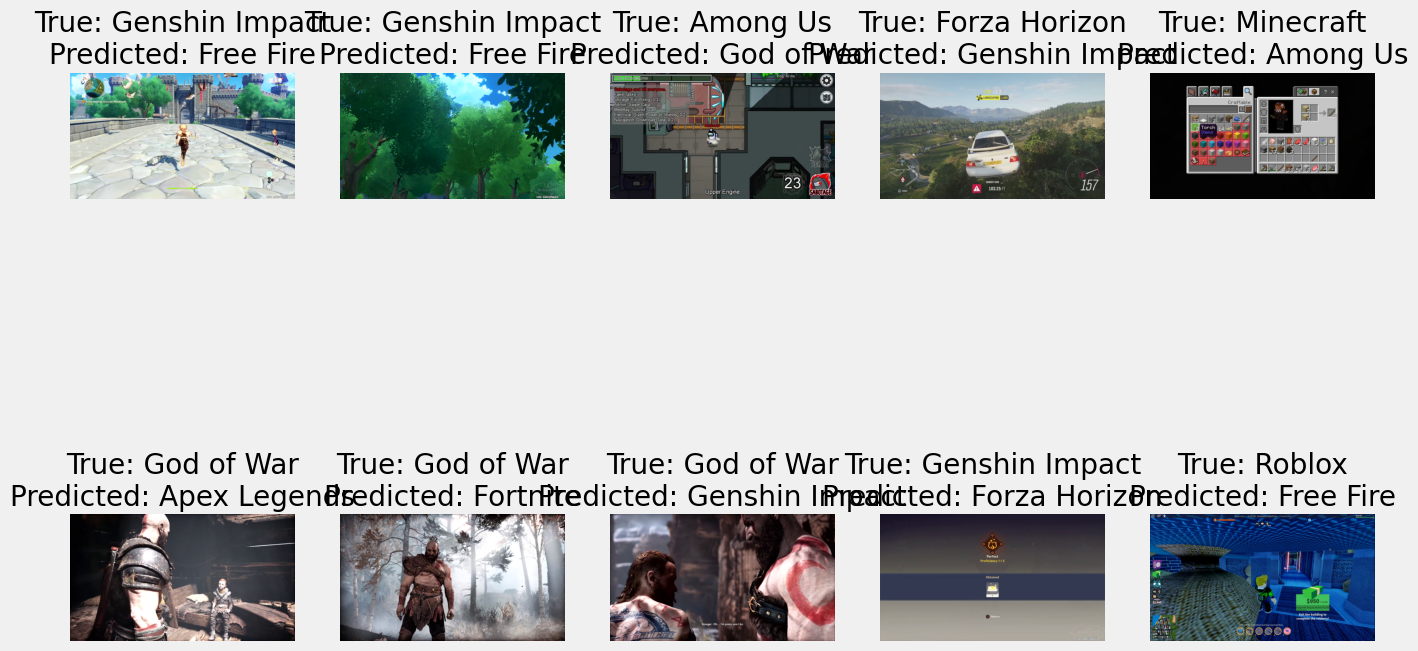

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report


# Evaluate on the test set
results = custom_model.evaluate(test_gen, verbose=1)

print("Test Loss:", results[0])
print("Test Accuracy:", results[1])

# Get predictions for the test set
predictions = custom_model.predict(test_gen)
predicted_classes = np.argmax(predictions, axis=1)

# Get true classes
true_classes = test_gen.classes

# Get class labels
class_labels = list(test_gen.class_indices.keys())

# Calculate and display the confusion matrix
conf_mat = confusion_matrix(true_classes, predicted_classes)
plt.imshow(conf_mat, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Display classification report
clr = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(clr)

# Display some misclassified examples
misclassified_indices = np.where(predicted_classes != true_classes)[0]

plt.figure(figsize=(15, 10))
for i, idx in enumerate(misclassified_indices[:10]):
    img_path = test_gen.filepaths[idx]
    img = plt.imread(img_path)
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(f"True: {class_labels[true_classes[idx]]}\nPredicted: {class_labels[predicted_classes[idx]]}")
    plt.axis('off')

plt.show()
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Assuming 'custom_model' is your trained model
# Assuming 'test_gen' is your test data generator

# Evaluate on the test set
results = custom_model.evaluate(test_gen, verbose=1)

print("Test Loss:", results[0])
print("Test Accuracy:", results[1])

# Get predictions for the test set
predictions = custom_model.predict(test_gen)
predicted_classes = np.argmax(predictions, axis=1)

# Get true classes
true_classes = test_gen.classes

# Get class labels
class_labels = list(test_gen.class_indices.keys())

# Calculate and display the confusion matrix
conf_mat = confusion_matrix(true_classes, predicted_classes)
plt.imshow(conf_mat, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Display classification report
clr = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(clr)

# Display some misclassified examples
misclassified_indices = np.where(predicted_classes != true_classes)[0]

plt.figure(figsize=(15, 10))
for i, idx in enumerate(misclassified_indices[:10]):
    img_path = test_gen.filepaths[idx]
    img = plt.imread(img_path)
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(f"True: {class_labels[true_classes[idx]]}\nPredicted: {class_labels[predicted_classes[idx]]}")
    plt.axis('off')

plt.show()


In [56]:
from sklearn.metrics import classification_report, confusion_matrix

# Assuming 'test_gen' is your test generator
test_gen.reset()
y_true = test_gen.classes

# Generate predictions
y_pred = custom_model.predict(test_gen)

# Convert predictions to class labels
y_pred_labels = np.argmax(y_pred, axis=1)
class_labels = list(train_gen.class_indices.keys())

# Generate classification report and confusion matrix
classification_rep = classification_report(y_true, y_pred_labels, target_names=class_labels)
conf_matrix = confusion_matrix(y_true, y_pred_labels)

# Print classification report
print(classification_rep)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)


63/63 [==============================] - 16s 242ms/step
                precision    recall  f1-score   support

      Among Us       0.97      0.99      0.98       196
  Apex Legends       0.80      0.82      0.81       177
      Fortnite       0.89      0.81      0.84       202
 Forza Horizon       0.85      0.83      0.84       215
     Free Fire       0.82      0.93      0.87       196
Genshin Impact       0.77      0.79      0.78       224
    God of War       0.88      0.85      0.87       196
     Minecraft       0.90      0.89      0.90       189
        Roblox       0.87      0.84      0.86       203
      Terraria       0.99      0.98      0.98       202

      accuracy                           0.87      2000
     macro avg       0.87      0.87      0.87      2000
  weighted avg       0.87      0.87      0.87      2000

Confusion Matrix:
[[194   1   0   0   0   0   1   0   0   0]
 [  0 145   7   2   2   7   7   0   7   0]
 [  0  17 163   4   1   7   2   5   2   1]
 [  1   2 